# Introduction
The aim of this project is to successfully develop a model that can predict soil moisture content on the 30th day ahead of the data, in other words, to successfully forecast the soil moisture content of the ground from the data that is provided by the German Meteorological Service from Münster, Deutscher Wetterdienst (n.d.), by utilizing either non-neural machine learning models or models that utilize neural networks and compare the outcomes and determine which method is more suitable in forecasting said values.
From the non-neural machine learning methods two models will be tested; a Linear Regression model and a Random Forest Regressor will be used and after evaluation, only one will be used to forecast. When developing the neural network model, a LSTM (Long Short-Term Memory)  will be used.

## The Contents of the Dataset
**DATUM**: The datetime column

**STATIONS_ID**	DWD weather station ID
  * 1766 = Münster/Osnabrück

**QN_4**: quality level of TT_TER and RF_TER columns
  * 1- only formal control during decoding and import
  * 2- controlled with individually defined criteria
  * 3- ROUTINE control with QUALIMET and QCSY
  * 5- historic, subjective procedures
  * 7- ROUTINE control, not yet corrected
  * 8- quality control outside ROUTINE
  * 9- ROUTINE control, not all parameters corrected
  * 10- ROUTINE control finished, respective corrections finished

**TT_TER**: air temperature

**RF_TER**: relative humidty

**VGSL**: real evapotranspiration over gras and sandy loam (mm)

**TS05**: mean daily soil temperature in 5 cm depth for uncovered typical soil (°C)

**BF10**: soil moisture under grass and sandy loam between 0 and 10 cm depth in % plant useable water (%nFK) (Gyarmathy, 2022)

# Approach
There are many available programming languages that can be used for data science purposes, such as R or even a more general use languages such as C# to conduct similar projects, such as forecasting, speech recognition, etc. However, there are two main programming languages preferred by data scientists worldwide, one being R and the second one being Python. For the purpose of completing this project the language used is Python due to 2 key reasons. The first reason being is the already established knowledge and experience using Python And the unfamiliarity of using R, although it would be interesting to compare the two programming languages, the sheer familiarity and ease of use of Python makes it a great tool for this project. The second reason being the popularity of Python and the ease of use of said programming language. Moreover, the abundance of data science libraries that is available for Python.

As mentioned before, since there are so many libraries that are available for Python, we had to choose between two main libraries that will be used for this project, that being Pytorch and Tensorflow Keras. While many regard Pytorch to be an easier alternative to learn, during our studies, we have mainly focused on tensor flow and Keras when learning about deep learning and neural networks. Furthermore, tensor flow 1 had a very steep learning curve and the library wasn't very user friendly and with the rise of Tensorflow 2 and the integration with Keras, it has become easier to learn, provides a more user-friendly approach than its predecessor, and has many tools that make it a more desirable library for data scientists. Lastly, since the aim of this project is to compare non-neural machine learning models with neural network models, another widely popular tool that will be used is SciKit learn for the non-neural machine learning models.

## Model Selection

It was briefly touched upon in the introduction that two models will be used, one being linear regression and the second one being an LSTM model. However, the plan beforehand was to incorporate many other different models and test them each. On the non neural machine learning side, many other regressors were to be used other than linear regression such as random forest regressor, etc. and timeseries specific models such as AutoReg(), ARIMA, SARIMA and SARIMAX. These were the models that needed to be tested and the most effective model was to be used for the forecast of the soil moisture content.

The reason for the incorporation of autoregressive models was the following. As many of the autoregressive regression models is built on top of the concept of autocorrelation and partial autocorrelation, or in other words, where the dependent variable depends on the past values of itself. An example might be where temperature today may depend on the temperature yesterday and the days before.  Unfortunately due to heavy time constraints and hardware difficulties, the auto regressive models had to be cut to prioritize the linear regression model and the LSTM model. 

When selecting a neural network model to predict the soil moisture levels, it was important to review the options. While there are many good models for predicting time series data, ultimately using an LSTM was chosen as the favorable approach due to familiarity. Whilst recurrent neural networks (RNN) have short term memory that utilize past data in the current neural network, which makes it ideal for predicting data in a time series, most recurrent neural networks face the problem of vanishing gradients, which can be interpreted as a loss in information due to the repeated use of the recurrent weight matrix. However, in an LSTM model, and identify function is managed by a set of gates that replaces the recurrent weight matrix. The weights are controlled by the input, output, and forget gates, which work together to generate the long-term memory function and in turn eliminates the vanishing gradient problem.

In [ ]:
!wget https://drive.google.com/uc?export=download&id=173tvWt-qPyAqZJc1KoBiUHgoSg6nLUtT

In [4]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, LSTM
# from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Preparation

Before any manipulation of the data were to occur it is important to analyze the data set before any modifications are made on it.  It is also important to set a random seed for reproducibility of the project.  Since all the information regarding the columns was provided in the project description before, we can read the CSV while simultaneously parsing the dates column labeled as DATUM.  It is important to analyze the data and its properties, such as the variables, columns, properties, mean, variance, standard deviation, etc.  and to visualize the data set  as simple visualization can give away any potential outliers, errors, NaN values, and be able to identify underlying trends and/or seasonality. After printing out the relevant information, it can be concluded that the data set contains a little over 35,000 records, data spanning from the beginning of the year 1991 to the end of year 2021.  The data set also contains seven additional features that have been described in the above paragraphs.  After calling the .info() function, it can be observed that the DATUM column is a datetime64 object and the data set does not contain any null values and that two of the columns are indeed measurements taken three times a day.

 

In [5]:
# Set random seed for reproductibility
random_seed = 69
np.random.seed(random_seed)

# Read the dataset and print out the information
df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df

,DATUM,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,1766,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,1766,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,1766,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,1766,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,1766,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...,...
35667,2021-12-30 00:00:00,1766,1,11.6,90.0,0.8,9.4,104
35668,2021-12-30 06:00:00,1766,1,11.1,98.0,0.8,9.4,104
35669,2021-12-30 12:00:00,1766,1,14.3,83.0,0.8,9.4,104
35670,2021-12-30 18:00:00,1766,1,13.5,90.0,0.8,9.4,104


In [6]:
# Visualize the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [7]:
df.describe()

,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
count,35672.0,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,1766.0,8.641540,10.755136,76.796675,1.236676,11.096577,70.367739
std,0.0,2.772131,7.591943,18.688003,0.978120,7.684733,37.325784
min,1766.0,1.000000,-21.300000,-999.000000,0.000000,-8.000000,0.000000
25%,1766.0,10.000000,5.200000,65.000000,0.500000,4.600000,40.000000
50%,1766.0,10.000000,10.600000,81.000000,1.000000,10.900000,87.000000
75%,1766.0,10.000000,16.100000,91.000000,1.800000,17.500000,102.000000
max,1766.0,10.000000,37.700000,100.000000,6.300000,29.200000,111.000000


In [8]:
print(df['STATIONS_ID'].unique())
print(df['QN_4'].unique())

[1766]
[10  3  1]


Lastly, the describe function also gives us a lot of. Lastly, the describe function also gives us a lot of useful information. From this table we can conclude that the stations ID. Dropped as it only contains a single variable 1766.  Another feature that can be excluded is feature QN_4 as the data is mostly category 10 with a few categories 3 and 1.  We can also conclude that RF_TER has at least one obvious outlier, that being -999.  As this variable stands for relative humidity, such a low variable is impossible and can be safely discarded.  To get a better understanding of this dataset, the columns can also be plotted into a graph for better visualization purposes.

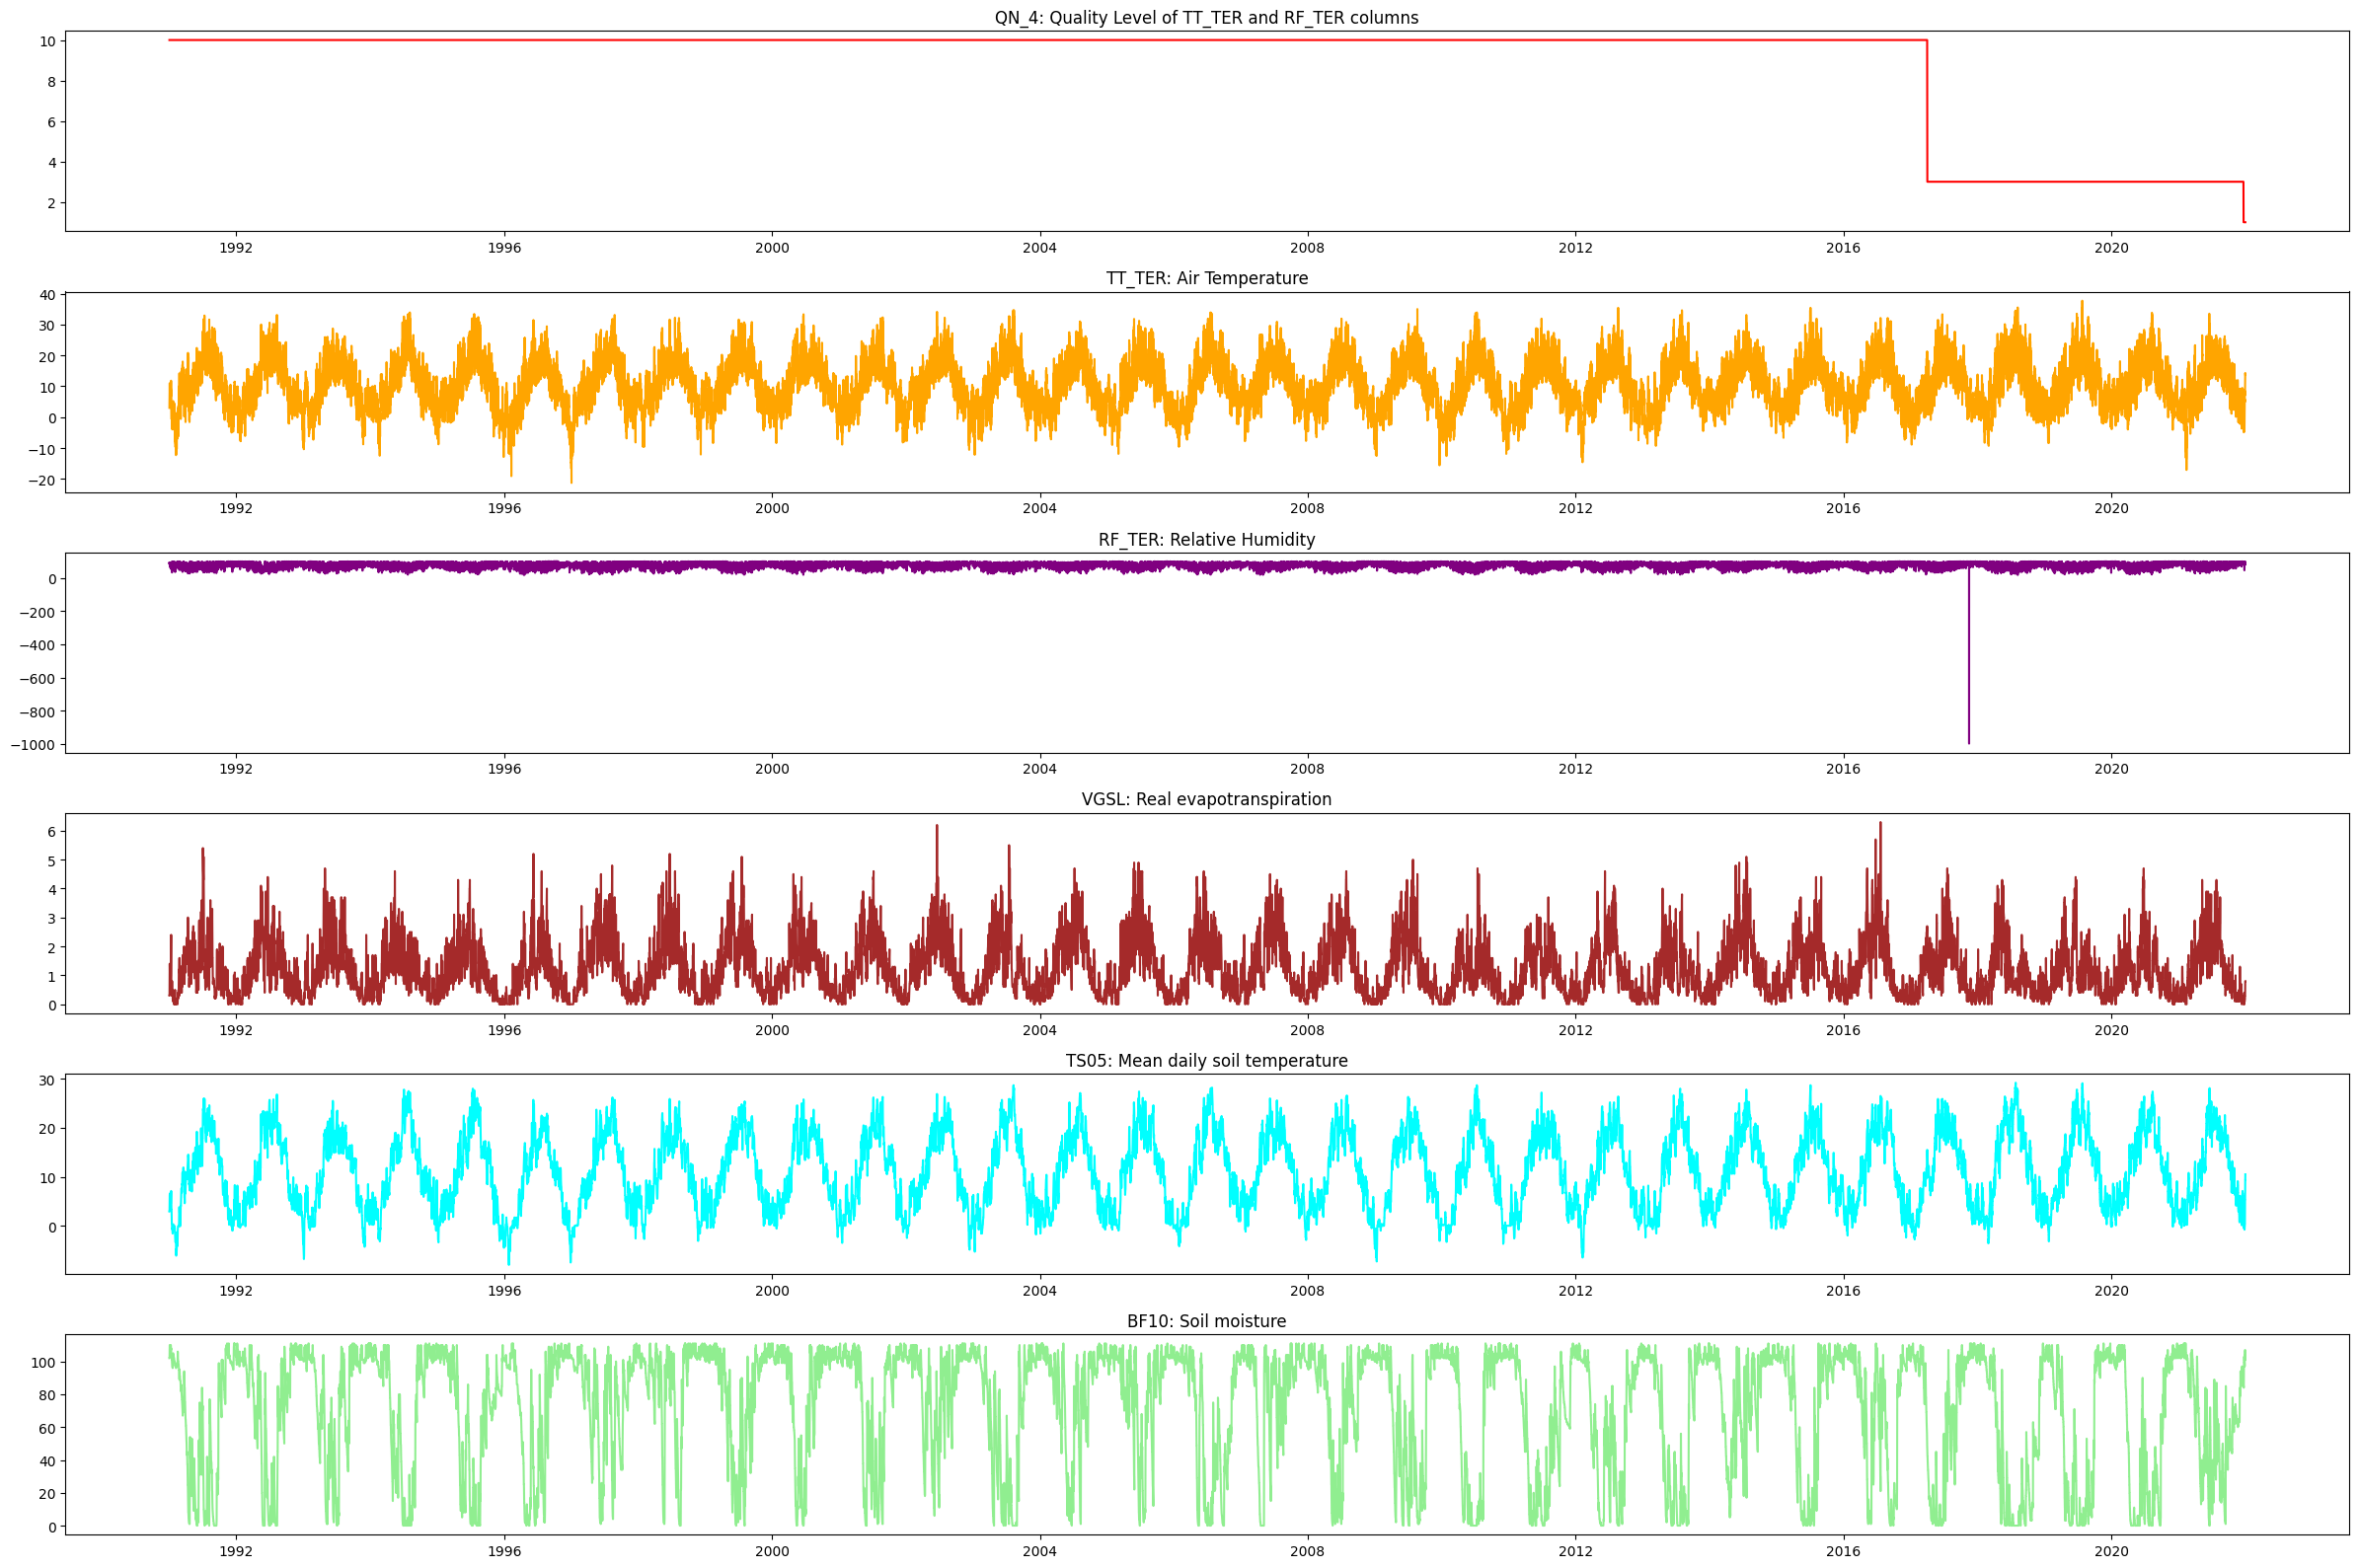

In [9]:
plt.figure(figsize=(24,16))

plt.subplot(6, 1, 1)
plt.title('QN_4: Quality Level of TT_TER and RF_TER columns')
plt.plot(df['DATUM'],df['QN_4'], c = 'red')

plt.subplot(6, 1, 2)
plt.title('TT_TER: Air Temperature')
plt.plot(df['DATUM'],df['TT_TER'], c = 'orange')

plt.subplot(6, 1, 3)
plt.title('RF_TER: Relative Humidity')
plt.plot(df['DATUM'],df['RF_TER'], c = 'purple')

plt.subplot(6, 1, 4)
plt.title('VGSL: Real evapotranspiration')
plt.plot(df['DATUM'],df['VGSL'], c = 'brown')

plt.subplot(6, 1, 5)
plt.title('TS05: Mean daily soil temperature')
plt.plot(df['DATUM'],df['TS05'], c = 'cyan')

plt.subplot(6, 1, 6)
plt.title('BF10: Soil moisture')
plt.plot(df['DATUM'],df['BF10'], c = 'lightgreen')

plt.tight_layout()
plt.show()

Before starting the data cleaning process, it is also important to view the correlation matrix between the different features to see if there is any relationship between them and to see what sort of effect the independent variables have on the dependent variable. This step is very important as it determines which columns will be dropped and which will be kept and used in the future to predict the soil moisture content in the ground.

After careful observations and considerations, it was determined that going forward, the only necessary columns will be the soil moisture column (BF10) and the DATUM column, which will be used as an index in the future. The reason for the following decision is that the STATIONS_ID column is unnecessary as there is only one station that has done all the measurements, therefore it is redundant. The column QN_4 is also unnecessary as it only displays the category of measurements and lastly, all the other columns except for column RF_TER show a negative correlation with our dependent variable of BF_10.

C:\Users\Robert Rompf\AppData\Local\Temp\ipykernel_15368\434535873.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sns.heatmap(df.drop('STATIONS_ID', 1).corr(), cmap="YlGnBu", annot=True)
C:\Users\Robert Rompf\AppData\Local\Temp\ipykernel_15368\434535873.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop('STATIONS_ID', 1).corr(), cmap="YlGnBu", annot=True)


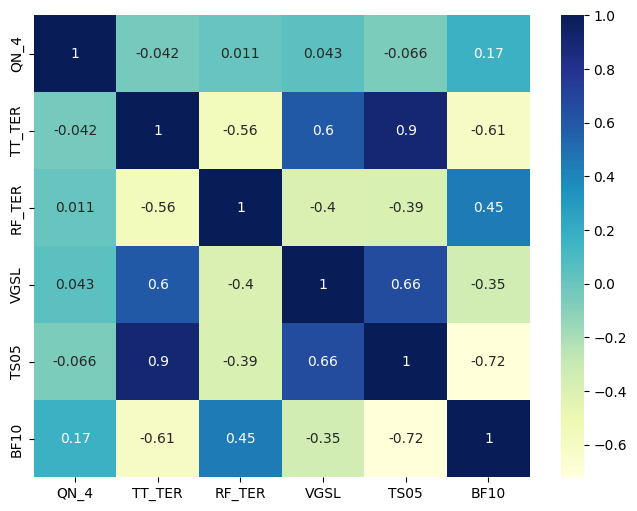

In [10]:
df = df[df.RF_TER > 0]
# DataFrame Correletion Heatmap
plt.figure(figsize = (8,6))
sns.heatmap(df.drop('STATIONS_ID', 1).corr(), cmap="YlGnBu", annot=True)
plt.show()

In [11]:
df2 = df.copy()
df2 = df2[["DATUM", "BF10"]]
df2.DATUM = df2.DATUM.astype('datetime64[ns]')
df2 = df2.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
df2['BF10'] = df2["BF10"].astype('int32')
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1991-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   BF10    11323 non-null  int32
dtypes: int32(1)
memory usage: 132.7 KB


In [12]:
df2

,BF10
DATUM,
1991-01-01,102
1991-01-02,110
1991-01-03,110
1991-01-04,106
1991-01-05,109
...,...
2021-12-27,97
2021-12-28,104
2021-12-29,107


 After cleaning the dataset, it is important to visualize the soil moisture values over the years. In the beginning, the hypothesis stated that the soil moisture content over the year is a seasonal occurrence, or in other words, cyclic. Henceforth, during the winter months the soil moisture contents will be high and during the summer months due to heat and higher rates of evaporation, the soil moisture content will be low.  After visualizing the soil moisture content over the years, we can see that this is pretty much the case.

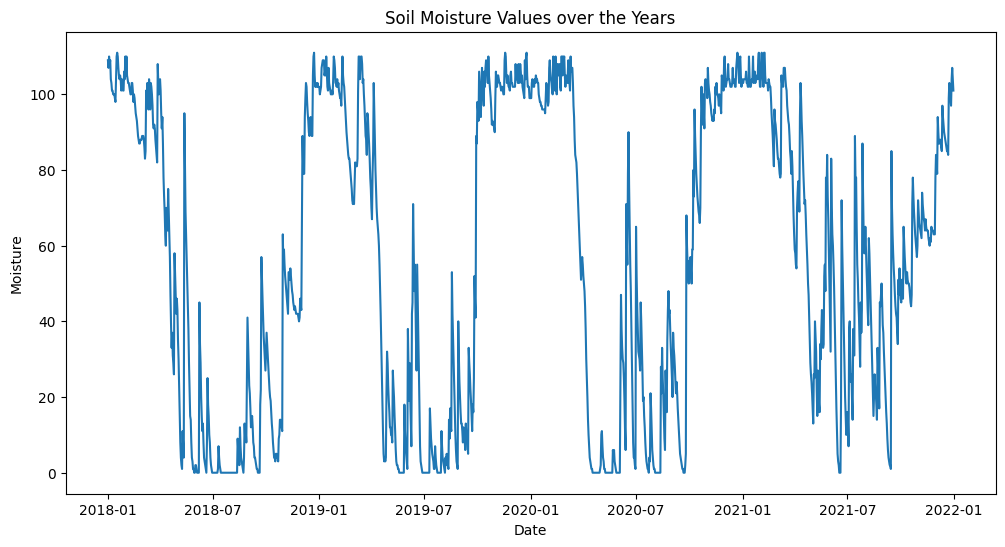

In [13]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(df2['BF10']['2018':])

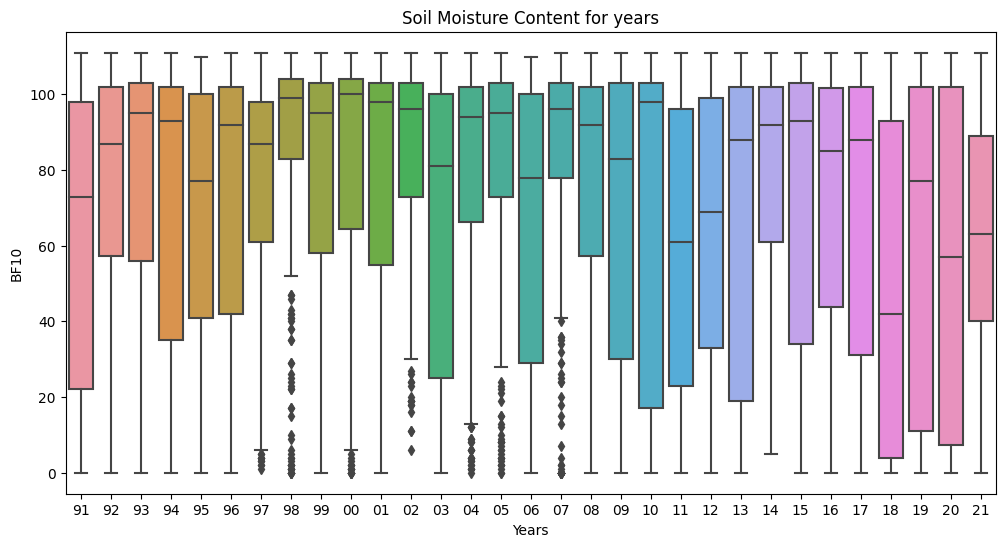

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=df2.index.strftime("%y"), y=df2["BF10"])
plt.title("Soil Moisture Content for years")
plt.xlabel("Years")
plt.show()

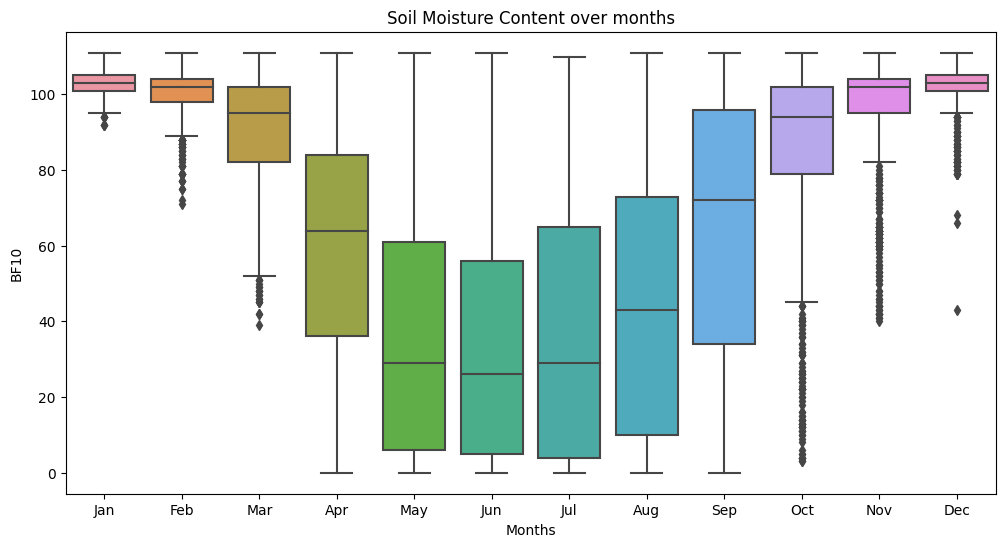

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=df2.index.strftime("%b"), y=df2["BF10"], ax=ax)
plt.title("Soil Moisture Content over months")
plt.xlabel("Months")
plt.show()

## TOOLS AND IMPLEMENTATION

### Linear Regression and Random Forest Regression using RF_TER as independent variable

This section will explore the differences between using a linear regression model and a random forest regressor in predicting future values using the column RF_TER, which stands for the relative humidity.

Linear regression is one of the most well utilized types of regressions that work great with Using it as a multivariate regression model. This means that it is an excellent tool used to predict the dependent variable from an independent variable. On the other hand, there is the random forest regression model, which unlike the linear regression model, produces better results when working with large scale datasets and are able to work better with missing data by creating estimates. Moreover, the random forest regressor is a great tool when the dataset has non-linear relationships between input features and the dependent variable. Unlike a regular decision tree regressor, the random forest Regressor is an ensemble of decision trees, which means that the random forest regressor creates many different trees and each of the decision trees makes its own individual prediction by the end. Lastly, the regressor uses the average of all of the trees (the forest) to create a prediction, which many people consider to be a more accurate prediction that using a simple Linear Regression.

For the following section of the code, I have copied the data frame to another data frame called reindex_df where I have copied over the date column, the soil moisture, and the relative humidity.  After that I have made another modification to this data frame where I have grouped together the data frame by date and combined the three measurements taken one day and condensed it into a single measurement once per day. This was done because the relative humidity did not change substantially throughout the day or did not have an impact on the soil moisture levels for that day. Therefore, using the average values per day for these two columns is sufficient, as there is no change in soil moisture content.

In [16]:
# Create new reindexed dataframe
reindexed_df = df.copy()
reindexed_df = reindexed_df[["DATUM", "BF10", "RF_TER"]]
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df = reindexed_df.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
reindexed_df['BF10'] = reindexed_df["BF10"].astype('int32')
reindexed_df['RF_TER'] = reindexed_df["RF_TER"].astype('float32')
reindexed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1991-01-01 to 2021-12-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BF10    11323 non-null  int32  
 1   RF_TER  11323 non-null  float32
dtypes: float32(1), int32(1)
memory usage: 176.9 KB


After creating the data frame that we will use for the following models, the data needs to be split into training and testing data to ensure that the model can generalize outside of the training data. There are many different ways to split your data set into a train and test split. For this project the SciKit learn library will be used to split the data.  After fitting both the random forest regressor and the linear regression model, we will use the predict function on the test data to see how well the models performed.

In [17]:
# Divide the dataset into train and test data
X = reindexed_df[["RF_TER"]]
y = reindexed_df[['BF10']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.20, random_state = random_seed)

In [18]:
# Fit both models
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

C:\Users\Robert Rompf\AppData\Local\Temp\ipykernel_15368\2376955629.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor().fit(X_train, y_train)


In [19]:
# Test the model
forest_pred = forest.predict(X_test)
lr_pred = linear.predict(X_test)

predictions = pd.DataFrame(lr_pred, index = y_test.index, columns = ['Prediction_Linear'])
predictions['Prediction_Forest'] = forest_pred
predictions['Actuals'] = np.array(y_test)

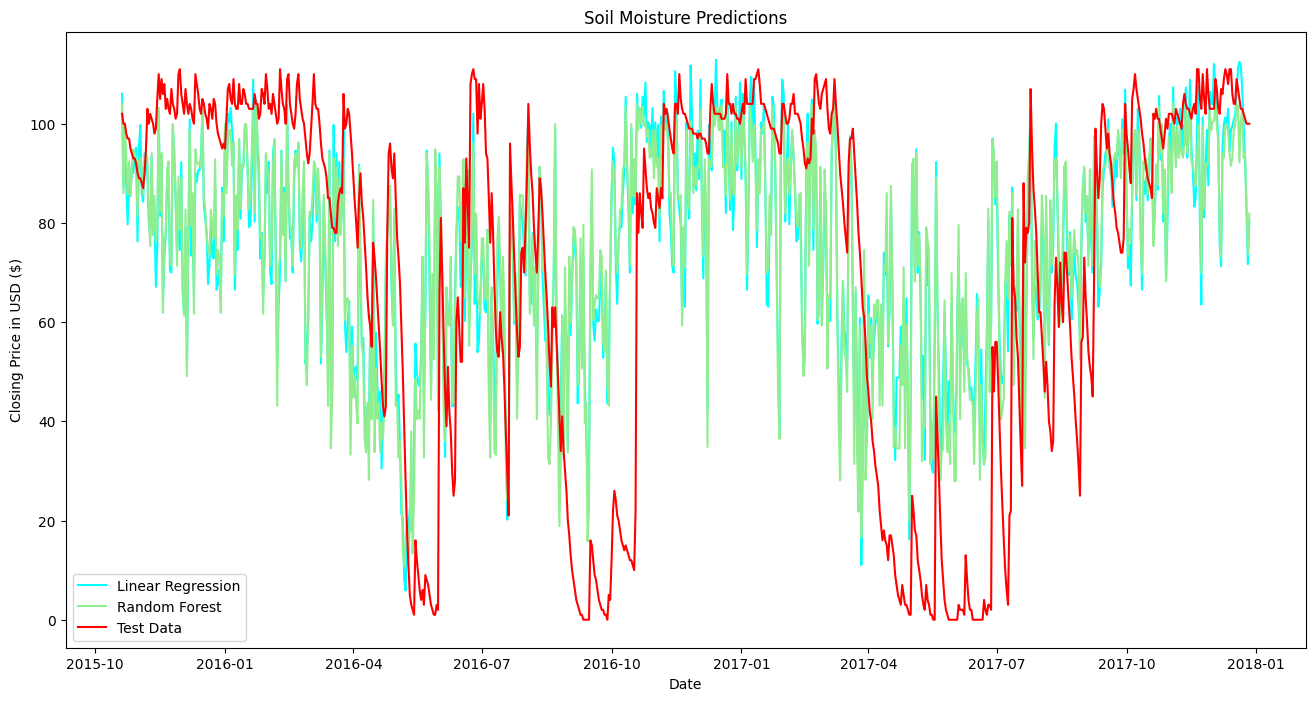

In [20]:
# Visualize the results
plt.figure(figsize=(16,8))
plt.title('Soil Moisture Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD ($)')

plt.plot(predictions['Prediction_Linear'][:800], label = 'Linear Regression', color = 'cyan')
plt.plot(predictions['Prediction_Forest'][:800], label = "Random Forest", color = 'lightgreen')
plt.plot(predictions['Actuals'][:800], label = 'Test Data', color = 'red')
plt.legend()
plt.show()

After visualizing the data predicted using the test data set, we can see that the model was not that accurate. Although it has managed to capture many of the trends such as high soil moisture content during the winter seasons and low soil moisture content during the summer months, the data generated is unfortunately too scattered to make any sort of predictions in the future, despite the fact the there was no shuffling when creating the train and test split.
To prove that the data is indeed inaccurate, we can print out the following metrics that will help us in evaluating the output data.  Here we can observe that the mean absolute error and the mean squared error between the two models is relatively the same. This concludes that neither the linear regression nor the random forest model performed better.  Moreover, when looking at the R squared score, we can see that it is a relatively low number of 0.2718 for the linear regression model and 0.2643 for the random forest regressor model.  Although both models have performed similarly, the linear regression model proved to be better overall, even if by the slightest.


In [21]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, lr_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, lr_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, lr_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, lr_pred), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 27.552
Mean Squared Error: 1161.9449
Root Mean Squared Error: 34.0873
(R^2) Score: 0.2718
Train Score: 38.85% and Test Score: 27.18% using Linear Regression.

RANDOM FOREST REGRESSOR: 
-------------------------------------------
Mean Absolute Error: 27.3551
Mean Squared Error: 1173.9302
Root Mean Squared Error: 34.2627
(R^2) Score: 0.2643
Train Score: 40.89% and Test Score: 26.43% using Random Forest Regressor.


### Forecasting BF10 using 1 day lag

After the failed attempt at creating an accurate model for the linear regression and random forest regressor using the relative humidity, lagged soil moisture levels can be used to predict current soil moisture levels. In essence this is using the auto regression (AR) part of an ARIMA model, as it uses past values to predict future values. By observing the plotted correlation matrix, we can see that the soil moisture content (BF_10) is highly correlated to itself, therefore making it possible to predict future values using past values. 

To observe the correlation between everyday values, we can plot an autocorrelation plot with a 30 day step lag data. Here it can be observed that the data highly correlates even after a 30 day lag period, although this can be misleading as it is possible that only a handful of lagged values correlate highly. To correct this, we can plot a partial autocorrelation with the same 30 lags and observe the correlation. Here it can be seen that the first data correlates highly with itself, as is to be expected, but only the second value correlates highly, with almost none after. To summarize, this means that predicting each day from the previous day yields a more accurate result than using 30 day old data to forecast.


c:\Users\Robert Rompf\OneDrive\Dokumenty\Coding\Machine_Learning_and_Deep_Learning\.venv\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Correlation coefficient')

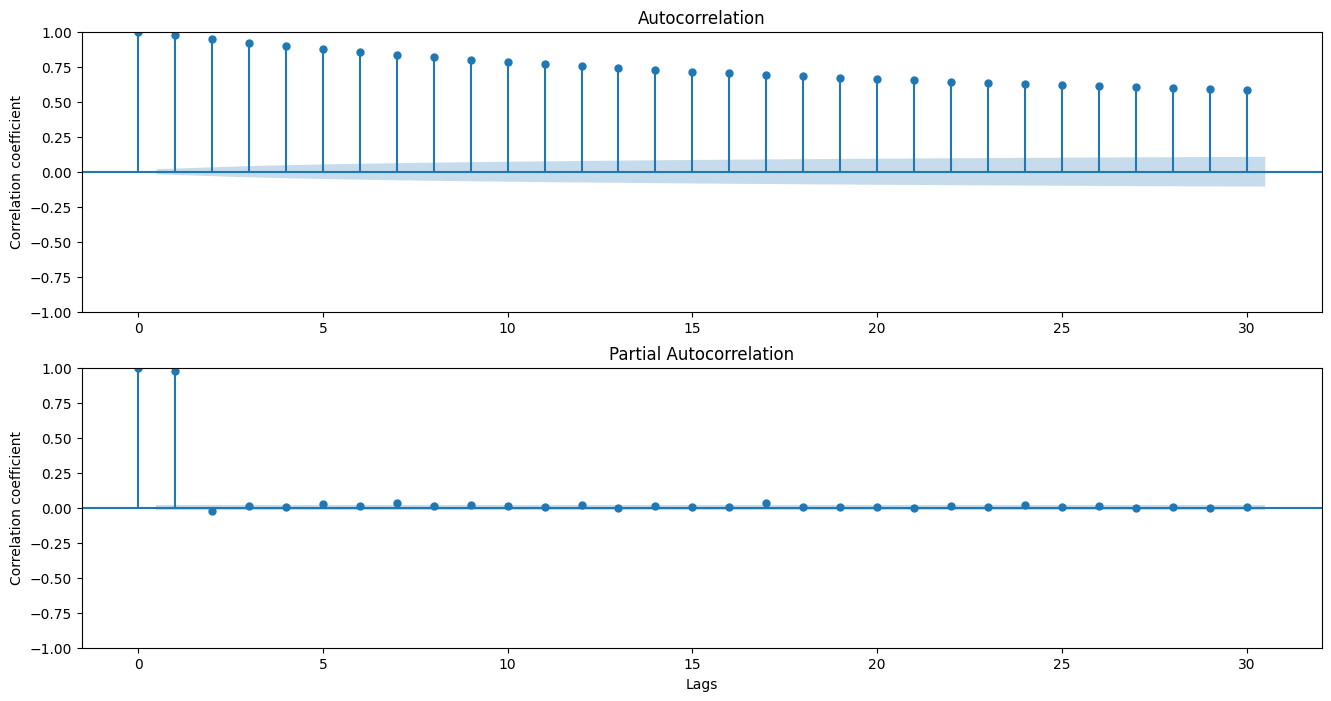

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
ax1.set_title('Autocorrelation')
_ = plot_acf(df2['BF10'], lags=30, ax = ax1)
ax2.set_title('Partial Autocorrelation')
_ = plot_pacf(df2['BF10'], lags=30, ax = ax2)
ax1.set_ylabel("Correlation coefficient")
ax2.set_xlabel("Lags")
ax2.set_ylabel("Correlation coefficient")

After observing through the partial autocorrelation, we will shift the target data set by one day. Before using a train test split we will use the MinMaxScaler to scale our data.

There are many different scaling and normalization functions that can be used. Here, a MinMaxScaler was chosen instead of a StandardScaler. It is a good idea to scale or normalize the data when implementing neural networks. According to Joseph and colleagues () The input variables are given weights by the machine learning models in accordance with the data points and inferences for the output. If the disparity between the data points is too big, the model will need to give the data points a bigger weight, and the model with a large weight value is frequently unstable in the end results. This implies that the model may provide subpar results or may perform poorly while during its learning phase. 

Both the standard scaler and the min Max scaler are solid choices. Both the standard scaler and the min max scaler are solid choices. Whilst the standard scalar scales that data set to the variance and standard distribution to equal to 1. The Min Max Scaler scales the data proportionally between a range of zero and one, which keeps the original shape of the data set. In this case, we just want to normalize the data by shrinking it to have smaller weights, therefore stabilizing the learning process for the model.

In [23]:
FORECAST = 1
df2['Prediction'] = df2[['BF10']].shift(-FORECAST)

# Create X and y variables shifted by the number of days we want to predict.
X = df2[['BF10']][:-FORECAST]
y = df2[['Prediction']][:-FORECAST]

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)
y = sc.fit_transform(y)

# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

# Visualize the shape of the train and test data
print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)

 (9057, 1) 
 (9057, 1) 
 (2265, 1) 
 (2265, 1)


In [24]:
# Fit both models
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

C:\Users\Robert Rompf\AppData\Local\Temp\ipykernel_15368\2376955629.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor().fit(X_train, y_train)


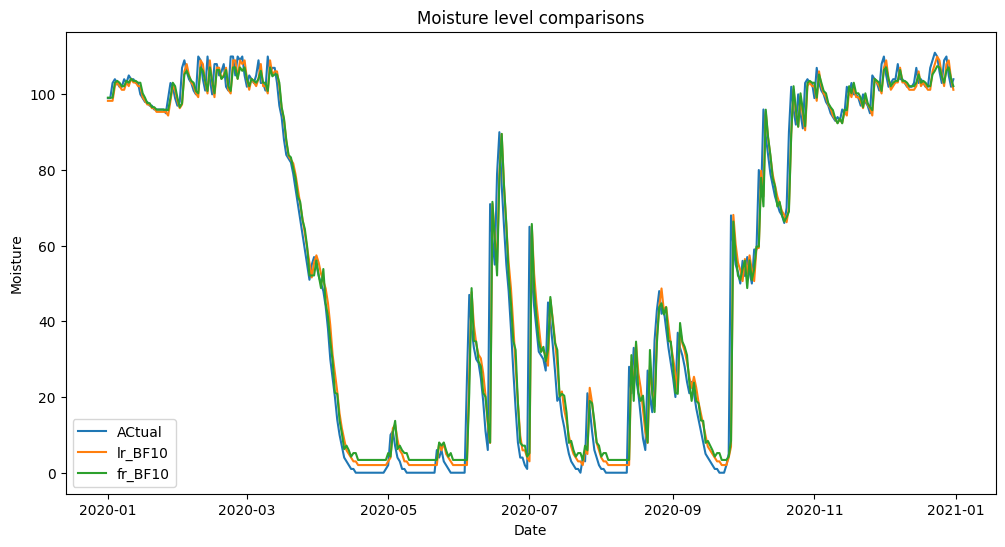

In [25]:
# Predict using the X_test dataset and evaluate the results
forest_pred = forest.predict(X_test)
predictions = linear.predict(X_test)

# Reverse the scaling to get full results
forest_pred = sc.inverse_transform(forest_pred.reshape(-1, 1))
predictions = sc.inverse_transform(predictions.reshape(-1, 1))

prediction = pd.DataFrame(predictions, index=df2[9057+FORECAST:].index, columns = ['lr_BF10'])
prediction['fr_BF10'] = forest_pred
prediction['Actuals'] = sc.inverse_transform(y_test.reshape(-1, 1))

prediction['lr_BF10'] = prediction[['lr_BF10']] # .shift(-FORECAST)
prediction['fr_BF10'] = prediction[['fr_BF10']] # .shift(-FORECAST)

# Visualize the results
plt.figure(figsize=(12,6))
plt.plot(prediction['Actuals']['2020'], label = 'ACtual')
plt.plot(prediction['lr_BF10']['2020'], label = 'lr_BF10')
plt.plot(prediction['fr_BF10']['2020'], label = 'fr_BF10')
plt.legend()
plt.title('Moisture level comparisons')  
plt.ylabel("Moisture")
plt.xlabel('Date')
plt.show()

We test the new approach by predicting and comparing the results to the X_test dataset. After we inverse the scaling to get the full values it can be observed that the model was very accurate with only minor differences between the actual data and the model results.  To inquire further on the results of the model, a code snippet from before was reutilized to evaluate the metrics of the model.  Interestingly, the eye squared score is negative.  A user going by the username Yang Li (2020) explained it in a stack exchange forum that there are two likely scenarios where a  Negative R squared score might appear.  The first being that the model did not fit the data provided or it fit badly.  The second option is not setting an intercept.  Interestingly, when using the dot .score() function both models achieved a score higher than 95%. Unfortunately, due to heavy time constraints, I did not have the time to improve upon the model and to investigate the negative R squared score.

In [26]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predictions), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predictions), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predictions), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 61.9511
Mean Squared Error: 5319.3147
Root Mean Squared Error: 72.9336
(R^2) Score: -41072.9279
Train Score: 94.54% and Test Score: 95.68% using Linear Regression.

RANDOM FOREST REGRESSOR: 
-------------------------------------------
Mean Absolute Error: 62.0051
Mean Squared Error: 5318.34
Root Mean Squared Error: 72.9269
(R^2) Score: -41065.4009
Train Score: 94.70% and Test Score: 95.66% using Random Forest Regressor.


### Forecasting using Linear Regression

Finally, it was decided that a linear regression model will be used to forecast 30 days ahead.  Two code snippets will be used that were provided to us during our lectures at IBS.  The following two functions utilize a time window and a forecast distance. A window size must be chosen that is not too big and not too small so that it avoids both overfitting and underfitting. In this instance I have chosen a window size of 365 as it takes into account the entire year and we have 30 years of data to work with. Naturally, since the aim of this project is to forecast 30 days ahead, we will use a forecast distance of 30.

In [27]:
def sliding_window_2D_from_df(df, targetcol_series, TIME_WINDOW, FORECAST_DISTANCE):
    X_df = pd.concat([df.shift(i) for i in range(1,TIME_WINDOW+1)], axis=1)\
                      .iloc[TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1]
    X_df.columns = pd.MultiIndex.from_product([range(1,TIME_WINDOW+1), df.columns])
    X_df.rename_axis(["lag", "variable"], axis=1, inplace=True)

    y_series = targetcol_series.shift( -FORECAST_DISTANCE + 1 )\
                      .iloc[ TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1 ]
    return X_df, y_series

def rolled_X_from_2D_sliding_window_df(X_df, timesteps):
    X_rolled = X_df.values.reshape(X_df.shape[0], timesteps, -1)
    return X_rolled

In [28]:
TIME_WINDOW=365
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df2[targetcol].astype('int32')

# train valid test split
X_train, X_test, y_train, y_test = train_test_split(df2[["BF10"]].astype('int32'), targetcol_series, test_size=0.2, shuffle=False)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)
print()

X_train, y_train = sliding_window_2D_from_df(X_train, y_train, TIME_WINDOW, FORECAST_DISTANCE)
X_test, y_test = sliding_window_2D_from_df(X_test, y_test, TIME_WINDOW, FORECAST_DISTANCE)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)
print()

X_train = rolled_X_from_2D_sliding_window_df(X_train, TIME_WINDOW)
X_test = rolled_X_from_2D_sliding_window_df(X_test, TIME_WINDOW)

y_train = y_train.ravel().reshape(-1,1)
y_test = y_test.ravel().reshape(-1,1)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)
print()

 (9058, 1) 
 (9058,) 
 (2265, 1) 
 (2265,)

 (8664, 365) 
 (8664,) 
 (1871, 365) 
 (1871,)

 (8664, 365, 1) 
 (8664, 1) 
 (1871, 365, 1) 
 (1871, 1)



After evaluating the linear regression model with the test data we can see that the accuracy of the model is around 54%. Unfortunately, the score is quite low, but when the model was used to forecast 30 days ahead, the forecast results were surprisingly accurate. Although the results might be a coincidence, we can conclude that the soil moisture content forecast 30 days ahead at around 92. This looks like an adequate score as it is during the winter months when the soil moisture content is at its highest. Therefore, having the soil moisture level of 92 would not be out of the question at this time of the year.

In [29]:
# Test the model
linear = LinearRegression()
linear.fit(X_train.reshape(X_train.shape[0], TIME_WINDOW), y_train)
predictions = linear.predict(X_test.reshape(X_test.shape[0],TIME_WINDOW))

# Print out the score
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predictions), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predictions), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predictions), 4))
accuracy = metrics.r2_score(y_test, predictions)*100
print(f'Accuracy: {round(accuracy, 2)}%')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 21.5665
Mean Squared Error: 754.7421
Root Mean Squared Error: 27.4726
(R^2) Score: 0.5377
Accuracy: 53.77%


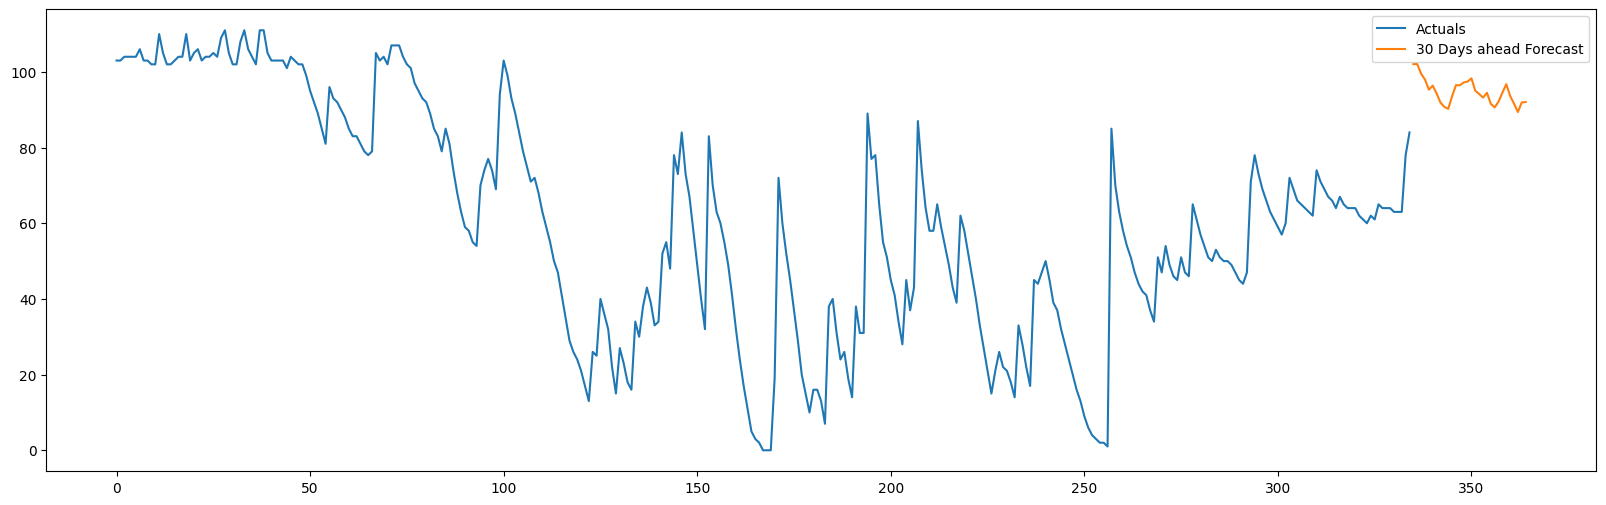

In [30]:
input = X_test[-1:].reshape(1,-1)
history = df2['BF10'].values
forecast = []

for i in range(30):
    yhat = linear.predict(input)
    input = list(input[0])
    pred = yhat[0][0]
    forecast.append(pred)
    input.append(pred)
    input = np.array(input[-TIME_WINDOW:]).reshape(1,TIME_WINDOW)
    
plt.figure(figsize = (20,6))
plt.plot(history[-TIME_WINDOW:-30], label='Actuals')
plt.plot(range(TIME_WINDOW-30,TIME_WINDOW),forecast, label ='30 Days ahead Forecast')
plt.legend()
plt.show()

In [31]:
print(f'Soil Moisture content forecast 30 days ahead {round(forecast[-1], 2)}')

Soil Moisture content forecast 30 days ahead 92.03


## LSTM Model for predicting soil moisture content
As it was mentioned above in the model selection section of this document an LSTM model was chosen as the methodology when choosing a model for predicting.  Well, there were many other recurrent neural networks (RNN), ultimately an LSTM model was chosen based on familiarity with the neural network and based on other literature where an LSTM model was used in predicting soil moisture content when using a recurrent neural networks.
The data preparation for the LSTM model is very similar to the data preparation step that we have taken for the linear regression model. Here we use the sliding window 2D from DF function that was provided to us during one of our lectures. And the rolled X from 2D sliding window DF, which was also provided to us from one of our lectures. The main aim of these two functions is to create a sliding window in the data to forecast a value for the day and slide the window along. This circle repeats until the forecast distance is met, in this case 30 days. Therefore, as it was already mentioned when viewing the partial autocorrelation. It is more efficient to predict one day at a time and use the predictions to forecast the other day ahead.

By the end we can view the shape of the rolled data. It creates a 3 dimensional shape that can be fed into the LSTM model. The first part of the shape is the number of values in the data and the second representing the the time window, which is filled with the data that slides forward. The only difference is that the time window is smaller and instead of 365 days, which is an entire year and in this case the time window was shortened to almost half a year, that being 180 days. The reason for the change in the time window is that, although it is unlikely, the previous time window might have been too big and could have cause issues in forecasting. Therefore, a shorter time frame does not negatively effect the dataset.

In [32]:
# Choose the window size and forecast distance
TIME_WINDOW=180
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df2[targetcol].astype('int32')

X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df2[["BF10"]].astype('int32'), targetcol_series, test_size=0.2, shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

# Prepare the model for training and tesing
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

y_train = y_train.ravel().reshape(-1,1)
y_valid = y_valid.ravel().reshape(-1,1)
y_test = y_test.ravel().reshape(-1,1)

print()
print("", X_rolled_train.shape, "\n", y_train.shape,
      "\n", X_rolled_valid.shape, "\n", y_valid.shape,
      "\n", X_rolled_test.shape, "\n", y_test.shape)


 (8849, 180, 1) 
 (8849, 1) 
 (923, 180, 1) 
 (923, 1) 
 (924, 180, 1) 
 (924, 1)


In [66]:
from tensorflow.keras import backend as be

LEARNING_RATE = 0.1
N_CELLS = 50
KERNEL = 'GlorotNormal'

## number of input variables: the final dimension in the 3D prepared data
column_count=X_rolled_train.shape[2]

be.clear_session()

model = Sequential()
model.add(LSTM(N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences=True, input_shape = (TIME_WINDOW, column_count)))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

## remember, we're doing regression, so choose loss (and output layer) accordingly!
model.compile(loss='mean_squared_error', optimizer='adamax')

print(model.summary())

2022-12-15 10:06:32.310097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-15 10:06:32.310124: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 10:06:32.310155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: rrompf-Desktop
2022-12-15 10:06:32.310165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: rrompf-Desktop
2022-12-15 10:06:32.310272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-12-15 10:06:32.310323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reporte

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 180, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 180, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

There were many different iterations on how to fit the data onto the model. The amount of epochs and the batch size were created at random, although many trials and errors were conducted manually. In the end, a sufficiently efficient model was created and this number of epochs (40) and a batch size of 200 seemed to be quite efficient.

There are many different callback options but the one used in this model is the Early Stopping callback that monitors loss with a patience of 3. This means that the model will stop training if it does not see any improvements after iterating through 3 epochs. This is beneficial as when selecting a large number of epochs, when the model is no longer capable of training, it might cause an issue of overfitting. Moreover, since it a computationally intensive task, depending on the model and learning rate the it may also take a large amount of time to iterate through a single epoch. Therefore, setting up a callback such as Early Stopping may prevent the model from overfitting, wasting memory and wasting time. The patience is a subjective choice and as such, a patience value of 3 was chosen as sometimes the model can still laern after 2 epochs that have not changed and anything after 3 was not beneficial and just extended the training time and increased the chances to overfit.

In [67]:
# Choose epoch amount and batch size
EPOCHS = 40
BATCH_SIZE = 200

# Crate a callback for efficiency purposes
my_callback = EarlyStopping(monitor='loss',
                            patience=3,
                            restore_best_weights = True)

# Train the LSTM model
history = model.fit(x=X_rolled_train,
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_rolled_valid,y_valid), 
                    epochs=EPOCHS,
                    verbose=1, 
                    shuffle=False,
                    callbacks = my_callback)

Epoch 1/40
45/45 [==============================] - 30s 500ms/step - loss: 6051.3032 - val_loss: 4087.3420
Epoch 2/40
45/45 [==============================] - 20s 451ms/step - loss: 5272.4541 - val_loss: 3740.0544
Epoch 3/40
45/45 [==============================] - 20s 452ms/step - loss: 4950.2173 - val_loss: 3572.2573
Epoch 4/40
45/45 [==============================] - 20s 452ms/step - loss: 4746.6333 - val_loss: 3434.5122
Epoch 5/40
45/45 [==============================] - 20s 453ms/step - loss: 4559.4497 - val_loss: 3306.6938
Epoch 6/40
45/45 [==============================] - 20s 454ms/step - loss: 4388.7202 - val_loss: 3186.8435
Epoch 7/40
45/45 [==============================] - 20s 453ms/step - loss: 4220.7944 - val_loss: 3073.4253
Epoch 8/40
45/45 [==============================] - 21s 458ms/step - loss: 4064.2097 - val_loss: 2965.4507
Epoch 9/40
45/45 [==============================] - 21s 459ms/step - loss: 3915.9766 - val_loss: 2863.4543
Epoch 10/40
45/45 [==================

After plotting the loss over iterations per epoch, it can be seen that the model was slowly becoming inefficient. Moreover, it can also be observed that the loss of the validation set has evened out, is not being trained and the training set loss has passed the validation set loss. This could indicate that an overfitting issue might arise. This would be the case if after some time the validation loss would increase and the training loss would stay the same or increase as well.

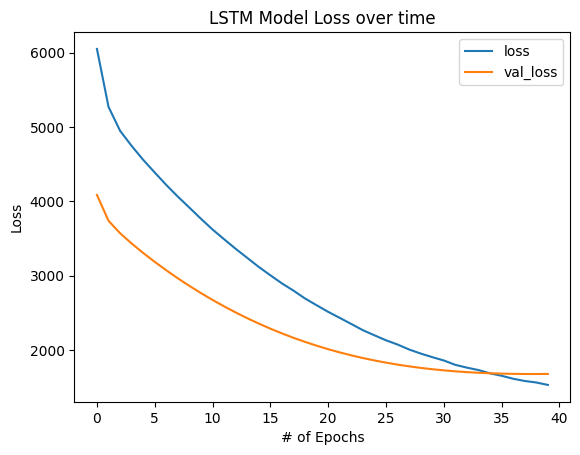

In [68]:
# Visualize the loss over epochs
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss over time')
plt.legend()
plt.show()

In [69]:
test_pred = model.predict(X_rolled_test).flatten()

29/29 [==============================] - 3s 58ms/step


In [71]:
test_pred.mean()

58.637085

# REFLECTION

In [ ]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
        
check_stationarity(df2)

The series is stationary


C:\Users\Robert Rompf\AppData\Local\Temp\ipykernel_10428\2753353209.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)


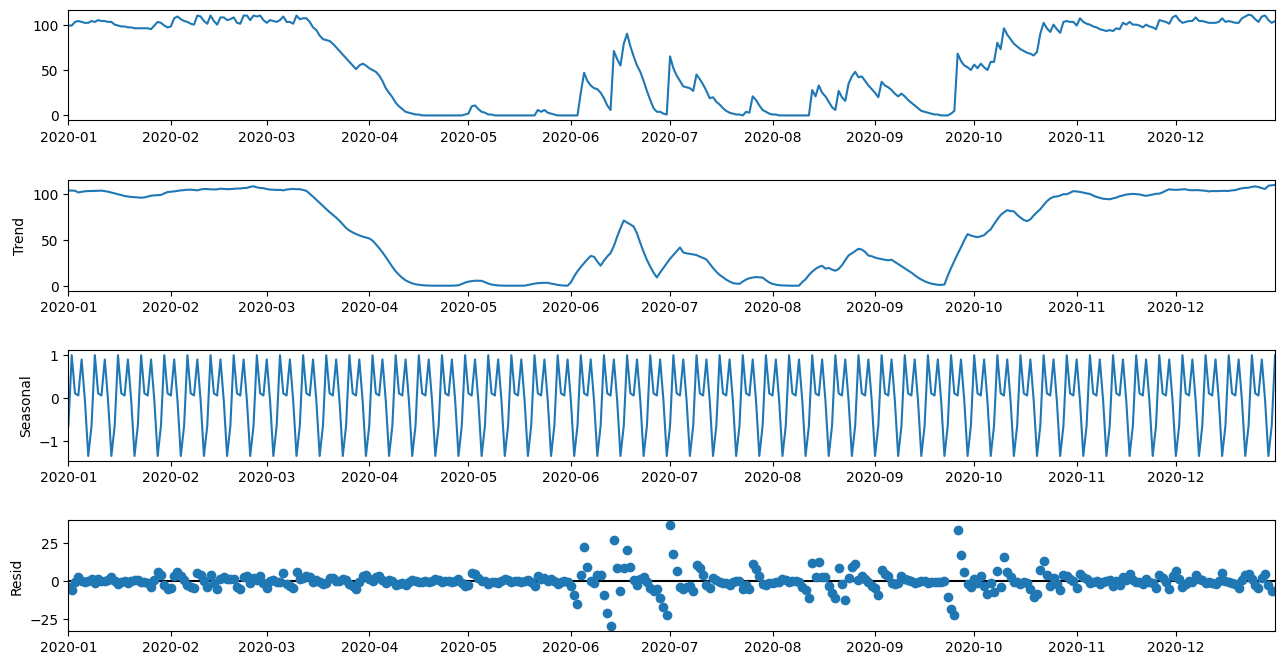

In [ ]:
analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)
    
fig = analysis.plot()
fig.set_size_inches(14, 7)
plt.show()